In [1]:
try:
    import google.colab
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

Note: not using Google CoLab


In [2]:
import numpy as np

## TORCH IMPORTS ##
import torch
import torch.nn as nn
from torch.autograd import Variable

import sys
import platform
import matplotlib.pyplot as plt

from numpy.fft import fft, ifft,fft2, ifft2, fftn, ifftn
from scipy import signal
import os
import scipy
import time

has_gpu = torch.cuda.is_available()
has_mps = torch.backends.mps.is_built()
device = "mps" if torch.backends.mps.is_built() \
    else "cuda:0" if torch.cuda.is_available() else "cpu"

print(f"Python Platform: {platform.platform()}")
print(f"PyTorch Version: {torch.__version__}")

# print(f"Scikit-Learn {sk.__version__}")
print("GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

Python Platform: Windows-11-10.0.26100-SP0
PyTorch Version: 2.6.0+cu124
GPU is available
MPS (Apple Metal) is NOT AVAILABLE
Target device is cuda:0


In [3]:
class Sin(nn.Module):
    def forward(self, input):
        return torch.sin(input)
    
class PINNs(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, num_layer):
        super(PINNs, self).__init__()
   

        layers = []
        for i in range(num_layer-1):
            if i == 0:
                layers.append(nn.Linear(in_features=in_dim, out_features=hidden_dim))
                layers.append(Sin())
                # layers.append(torch.sin(layers))
            else:
                layers.append(nn.Linear(in_features=hidden_dim, out_features=hidden_dim))
                layers.append(Sin())

        layers.append(nn.Linear(in_features=hidden_dim, out_features=out_dim))

        self.linear = nn.Sequential(*layers)

    def forward(self, xy, t):
        src = torch.cat([xy, t], dim=-1)
        return self.linear(src)
    

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [4]:
net = PINNs(in_dim=3, hidden_dim=32, out_dim=4, num_layer=3).to(device) #Input dimensions increased from 2 to 3 and Output dimensions from 3 to 4 to account for the increased spatial dimension (y)
net.apply(init_weights)
print(net) 
mse_cost_function = torch.nn.MSELoss() # Mean squared error
optimizer = torch.optim.Adam(net.parameters(),lr=0.001,)
optimizerL = torch.optim.LBFGS(net.parameters(),line_search_fn='strong_wolfe')

PINNs(
  (linear): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): Sin()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Sin()
    (4): Linear(in_features=32, out_features=4, bias=True)
  )
)


In [5]:
def get_boundary_rho_vel_phi(x_bc_l, x_bc_r, y_bc_b, y_bc_t, t, net):
    
    # X-direction boundaries (left)
    x_left = x_bc_l[:, 0:1].clone().requires_grad_(True)
    y_left = x_bc_l[:, 1:2].clone().requires_grad_(True)
    outputs_left = net(torch.cat([x_left, y_left], dim=1), t)
    rho_x_l, vx_x_l, vy_x_l, phi_x_l = outputs_left.chunk(4, dim=1)

    # X-direction boundaries (right)
    x_right = x_bc_r[:, 0:1].clone().requires_grad_(True)
    y_right = x_bc_r[:, 1:2].clone().requires_grad_(True)
    outputs_right = net(torch.cat([x_right, y_right], dim=1), t)
    rho_x_r, vx_x_r, vy_x_r, phi_x_r = outputs_right.chunk(4, dim=1)

    # Y-direction boundaries (bottom)
    x_bottom = y_bc_b[:, 0:1].clone().requires_grad_(True)
    y_bottom = y_bc_b[:, 1:2].clone().requires_grad_(True)
    outputs_left = net(torch.cat([x_bottom, y_bottom], dim=1), t)
    rho_y_b, vx_y_b, vy_y_b, phi_y_b = outputs_left.chunk(4, dim=1)

    # Y-direction boundaries (top)
    x_top = y_bc_t[:, 0:1].clone().requires_grad_(True)
    y_top = y_bc_t[:, 1:2].clone().requires_grad_(True)
    outputs_right = net(torch.cat([x_top, y_top], dim=1), t)
    rho_y_t, vx_y_t, vy_y_t, phi_y_t = outputs_right.chunk(4, dim=1)

    # Y-direction boundaries 
    #rho_y_b, vx_y_b, vy_y_b, phi_y_b = net(torch.cat([y_bc_b[:,0:1], y_bc_b[:,1:2]], dim=1), t).chunk(4, dim=1)
    #rho_y_t, vx_y_t, vy_y_t, phi_y_t = net(torch.cat([y_bc_t[:,0:1], y_bc_t[:,1:2]], dim=1), t).chunk(4, dim=1)

    # Potential gradients
    phi_x_l_x = torch.autograd.grad(phi_x_l, x_left, grad_outputs=torch.ones_like(phi_x_l), create_graph=True, retain_graph=True)[0]
    phi_x_r_x = torch.autograd.grad(phi_x_r, x_right, grad_outputs=torch.ones_like(phi_x_r), create_graph=True, retain_graph=True)[0]
    
    phi_y_b_y = torch.autograd.grad(phi_y_b, y_bottom, grad_outputs=torch.ones_like(phi_y_b), create_graph=True, retain_graph=True)[0]
    phi_y_t_y = torch.autograd.grad(phi_y_t, y_top, grad_outputs=torch.ones_like(phi_y_t), create_graph=True, retain_graph=True)[0]

    # Boundary residuals
    rho_b_x = rho_x_l - rho_x_r
    vx_b_x = vx_x_l - vx_x_r
    vy_b_x = vy_x_l - vy_x_r
    
    rho_b_y = rho_y_b - rho_y_t
    vx_b_y = vx_y_b - vx_y_t
    vy_b_y = vy_y_b - vy_y_t
    
    phi_b_x = phi_x_l - phi_x_r
    phi_b_y = phi_y_b - phi_y_t
    
    phi_x_b = phi_x_l_x - phi_x_r_x
    phi_y_b = phi_y_b_y - phi_y_t_y

    return rho_b_x, rho_b_y, vx_b_x, vx_b_y, vy_b_x, vy_b_y, phi_b_x, phi_b_y, phi_x_b, phi_y_b

def pde_residue(x, y, t, net):

    xy = torch.cat([x, y], dim=1)
    net_outputs = net(xy, t)
    
    rho, v_x, v_y, phi = net_outputs[:,0:1], net_outputs[:,1:2], net_outputs[:,2:3], net_outputs[:,3:4]

    rho_x = torch.autograd.grad(rho, x,grad_outputs=torch.ones_like(rho), create_graph=True)[0]
    rho_y = torch.autograd.grad(rho, y,grad_outputs=torch.ones_like(rho), create_graph=True)[0]
    rho_t = torch.autograd.grad(rho, t,grad_outputs=torch.ones_like(rho),create_graph=True)[0]

    v_x_x = torch.autograd.grad(v_x, x,grad_outputs=torch.ones_like(v_x), create_graph=True)[0]
    v_x_y = torch.autograd.grad(v_x, y,grad_outputs=torch.ones_like(v_x), create_graph=True)[0]
    v_y_x = torch.autograd.grad(v_y, x,grad_outputs=torch.ones_like(v_y), create_graph=True)[0]
    v_y_y = torch.autograd.grad(v_y, y,grad_outputs=torch.ones_like(v_y), create_graph=True)[0]
    
    v_x_t = torch.autograd.grad(v_x, t,grad_outputs=torch.ones_like(v_x), create_graph=True)[0]
    v_y_t = torch.autograd.grad(v_y, t,grad_outputs=torch.ones_like(v_y), create_graph=True)[0]

    phi_x = torch.autograd.grad(phi, x,grad_outputs=torch.ones_like(phi), create_graph=True)[0]
    phi_x_x = torch.autograd.grad(phi_x, x,grad_outputs=torch.ones_like(phi_x), create_graph=True)[0]

    phi_y = torch.autograd.grad(phi, y,grad_outputs=torch.ones_like(phi), create_graph=True)[0]
    phi_y_y = torch.autograd.grad(phi_y, y,grad_outputs=torch.ones_like(phi_y), create_graph=True)[0]

    rho_r = rho_t + v_x * rho_x + rho * v_x_x + v_y * rho_y + rho * v_y_y #The residue from the density equation, in the same format as in PINN-2DG
    v_x_r = rho * v_x_t + rho * (v_x * v_x_x + v_y * v_x_y) + cs * cs * rho_x + rho * phi_x #The momentum equation in 2D in X, in the same format as in PINN-2DG
    v_y_r = rho * v_y_t + rho * (v_y * v_y_y + v_x * v_y_x) + cs * cs * rho_y + rho * phi_y #The momentum equation in 2D in Y, in the same format as in PINN-2DG
    phi_r = phi_x_x + phi_y_y - const * (rho - rho_o) #The residue from the Poisson equation, in the same format as in PINN-2DG

    return rho_r, v_x_r, v_y_r, phi_r

In [6]:
## CASE 1           (refer to the paper for details)
lam_x = 7.0           # 2*pi/lam_x = k_x
lam_y = 7.0           # 2*pi/lam_y = k_y
lam = lam_x*lam_y/np.sqrt(lam_x**2 + lam_y**2) # 2*pi/lam = k = sqrt((k^2 = k_x^2 + k_y^2))
num_of_waves = 2
rho_1a = 0.03        # question 2a linear wave propagation

# ## CASE 2          (refer to the paper for details)
#lam = 7.0          # one wavelength
#num_of_waves = 3
#rho_1a = 0.3        # question 2a linear wave propagation

# ## CASE 2          (refer to the paper for details)
#lam = 5.0          # one wavelength
#num_of_waves = 3
#rho_1a = 0.03       # question 2a linear wave propagation

In [ ]:
### PROBLEM CONSTANTS ####
rho_o = 1          ## zeroth order density
cs = 1.0           ##  Sound Speed
const = 1          ## we set 4 pi G  to 1
G = 1

#output_folder = "1D_fig" 
#os.makedirs(output_folder, exist_ok=True)


################ THE ANALYTIC MODEL ####################
  

jeans = np.sqrt(4*np.pi**2*cs**2/(const*G*rho_o)) #jeans length in GRINN paper

if lam_x > jeans:
    alpha_x = np.sqrt(const*rho_o-cs**2*(2*np.pi/lam_x)**2)
else:
    alpha_x = np.sqrt(cs**2*(2*np.pi/lam_x)**2 - const*rho_o)

if lam_y > jeans:
    alpha_y = np.sqrt(const*rho_o-cs**2*(2*np.pi/lam_y)**2)
else:
    alpha_y = np.sqrt(cs**2*(2*np.pi/lam_y)**2 - const*rho_o)

# v_1a = (cs*rho_1a)/rho_o ## velocity perturbation without gravity

v_1ax = ((cs*2/rho_o) - (const*lam**2/4*np.pi**2)) * (rho_1a/alpha_x)*(2*np.pi/lam_x) # With gravity in x

v_1ay = ((cs*2/rho_o) - (const*lam**2/4*np.pi**2)) * (rho_1a/alpha_y)*(2*np.pi/lam_y) # With gravity in y

def fun_rho_0(x, y):
    ''' Define initial condition for density Returning Eq (11a)'''
    #print('wavelength',lam)
    rho_0 = rho_o + rho_1a * np.cos((2*np.pi*x/lam_x) + (2*np.pi*x/lam_y))
    return rho_0

def fun_v_0(x, y):
    '''initial condition for velocity -- Returning Eq 11b'''
    
    if lam > jeans:
        v_0x = - v_1ax * np.sin(2*np.pi*x/lam_x)  #assuming x component of v_0 is v_1ax * np.sin(k_x*x)
        v_0y = - v_1ay * np.sin(2*np.pi*y/lam_y)  #assuming y component of v_0 is v_1ay * np.sin(k_y*y)

        v_0 =  v_0x + v_0y  ## This is for sound wave ## refer to the paper for details
    else:
        v_0x = v_1ax * np.sin(2*np.pi*x/lam_x)
        v_0y = v_1ay * np.sin(2*np.pi*y/lam_y)
        
        v_0 = v_0x + v_0y ## This is for the gravity wave
    return v_0x, v_0y, v_0


In [10]:
## TIME & SPACE
tmin = 0.
tmax = 1.

xmin = 0.
xmax = xmin+lam*num_of_waves

ymin = 0.
ymax = ymin+lam*num_of_waves

cs = 1.

### NUMBER OF COLLOCATION POINTS ##

N_0 = 10000   ## for IC
N_b = 10000   ## for BC
N_r = 30000  ## for Domain



############## IC setup ################

# Intial conditions collocation points
x_0 = np.random.uniform(low=xmin, high=xmax, size=(N_0,1))
y_0 = np.random.uniform(low=ymin, high=ymax, size=(N_0,1))
t_0 = np.zeros((N_0,1))

# Evaluate intitial condition at x_0
rho_0 = fun_rho_0(x_0, y_0)
v_0x, v_0y, v_0 = fun_v_0(x_0, y_0)

#IC torch variable
pt_x_0 = torch.from_numpy(x_0).float().to(device).requires_grad_(True)
pt_y_0 = torch.from_numpy(y_0).float().to(device).requires_grad_(True)
pt_t_0 = torch.from_numpy(t_0).float().to(device).requires_grad_(True)
pt_rho_0 = torch.from_numpy(rho_0).float().to(device)
pt_vel_0 = torch.from_numpy(v_0).float().to(device)

# ## Checking the initial profiles
# plt.scatter(x_0, rho_0,s=20, c='b', marker='o',label="Ini-Density")
# plt.scatter(x_0, v_0,s=2, c='r', marker='*',label="Ini-Velocity" )
# plt.legend()


############## BC setup ################

x_bc_l = np.hstack([xmin * np.ones((N_b, 1)), np.random.uniform(low=ymin, high=ymax, size=(N_b, 1))])
x_bc_r = np.hstack([xmax * np.ones((N_b, 1)), np.random.uniform(low=ymin, high=ymax, size=(N_b, 1))])
y_bc_b = np.hstack([np.random.uniform(low=xmin, high=xmax, size=(N_b, 1)), ymin * np.ones((N_b, 1))])
y_bc_t = np.hstack([np.random.uniform(low=xmin, high=xmax, size=(N_b, 1)), ymax * np.ones((N_b, 1))])

t_bc = np.random.uniform(low=tmin, high=tmax, size=(N_b,1))

#BC torch variable
pt_x_bc_l = torch.from_numpy(x_bc_l).float().to(device).requires_grad_(True)
pt_x_bc_r = torch.from_numpy(x_bc_r).float().to(device).requires_grad_(True)
pt_y_bc_b = torch.from_numpy(y_bc_b).float().to(device).requires_grad_(True)
pt_y_bc_t = torch.from_numpy(y_bc_t).float().to(device).requires_grad_(True)

pt_t_bc = torch.from_numpy(t_bc).float().to(device).requires_grad_(True)


############## PDE setup ################


x_collocation = np.random.uniform(low=xmin, high=xmax, size=(N_r,1))
y_collocation = np.random.uniform(low=ymin, high=ymax, size=(N_r,1))
t_collocation = np.random.uniform(low=tmin, high=tmax, size=(N_r,1))

#as torch variable
pt_x_collocation = torch.from_numpy(x_collocation).float().to(device).requires_grad_(True)
pt_y_collocation = torch.from_numpy(y_collocation).float().to(device).requires_grad_(True)
pt_t_collocation = torch.from_numpy(t_collocation).float().to(device).requires_grad_(True)

print(np.shape(pt_x_collocation))

# Move the neural network to the correct device
net = net.to(device)

wavelength 4.949747468305833
torch.Size([30000, 1])


In [11]:
from tqdm import tqdm
import time
iterations = 200
start = time.time()
def closure():

        ############## Loss based on initial conditions ###############

        net_ic_out = net(torch.cat([pt_x_0, pt_y_0], dim=1), pt_t_0) # output of rho(x,t=0), vel(x,t=0)

        rho_ic_out = net_ic_out[:,0:1]
        vel_x_ic_out = net_ic_out[:,1:2]
        vel_y_ic_out = net_ic_out[:, 2:3]

        mse_rho_ic =  mse_cost_function(rho_ic_out, pt_rho_0)
        mse_vel_x_ic =  mse_cost_function(vel_x_ic_out, pt_vel_0)
        mse_vel_y_ic =  mse_cost_function(vel_y_ic_out, pt_vel_0)

        ############# Loss based on boundary conditions #################

        (
            rho_b_x, rho_b_y,
            vel_b_x_x, vel_b_x_y,
            vel_b_y_x, vel_b_y_y,
            phi_b_x, phi_b_y,
            phi_x_x_b, phi_y_y_b
        ) = get_boundary_rho_vel_phi(pt_x_bc_l, pt_x_bc_r, pt_y_bc_b, pt_y_bc_t, pt_t_bc, net)


        mse_bc_rho_x = torch.mean(rho_b_x ** 2)
        mse_bc_rho_y = torch.mean(rho_b_y ** 2)
        mse_bc_vel_x_x = torch.mean(vel_b_x_x ** 2)
        mse_bc_vel_x_y = torch.mean(vel_b_x_y ** 2)
        mse_bc_vel_y_x = torch.mean(vel_b_y_x ** 2)
        mse_bc_vel_y_y = torch.mean(vel_b_y_y ** 2)
        mse_bc_phi_x = torch.mean(phi_b_x ** 2)
        mse_bc_phi_y = torch.mean(phi_b_y ** 2)
        mse_bc_phi_x_x = torch.mean(phi_x_x_b ** 2)
        mse_bc_phi_y_y = torch.mean(phi_y_y_b ** 2)

        ############## Loss based on PDE ###################################

        rho_r, v_x_r, v_y_r, phi_r = pde_residue(pt_x_collocation, pt_y_collocation, pt_t_collocation, net) # output of rho(x,t) and vel(x,t)


        mse_rho = torch.mean(rho_r ** 2) 
        mse_vel_x = torch.mean(v_x_r ** 2)
        mse_vel_y = torch.mean(v_y_r ** 2)
        mse_phi = torch.mean(phi_r ** 2)

        ################### Combining the loss functions ####################
        loss = (
            mse_rho_ic + mse_vel_x_ic + mse_vel_y_ic +  # Initial conditions
            mse_rho + mse_vel_x + mse_vel_y + mse_phi +  # PDE residuals
            mse_bc_rho_x + mse_bc_rho_y +               # Boundary: rho
            mse_bc_vel_x_x + mse_bc_vel_x_y +           # Boundary: vel_x
            mse_bc_vel_y_x + mse_bc_vel_y_y +           # Boundary: vel_y
            mse_bc_phi_x + mse_bc_phi_y +               # Boundary: phi gradients
            mse_bc_phi_x_x + mse_bc_phi_y_y             # Boundary: phi 2nd derivatives
        )
        optimizerL.zero_grad()
        loss.backward() # This is for computing gradients using backward propagationerivative of J w.r.t theta
        return loss
TOTAL_loss = []

## Using ADAM 

for i in tqdm(range(iterations)): 
    loss_ = optimizer.step(closure)
    TOTAL_loss.append(loss_.item())
    if i % 50 == 0:
        print("TOTAL LOSS ={:.2e}".format(loss_.item()))
print("INFO:Adam training done LBFGS initiated")       
## Using LBFGS after the initial ADAM training
for i in tqdm(range(iterations)): 
    loss_ = optimizerL.step(closure)
    TOTAL_loss.append(loss_.item())
    if i % 50 == 0:
        print("TOTAL LOSS ={:.2e}".format(loss_.item()))
end = time.time()
print("Total time = {} sec ".format(end - start))

  2%|▏         | 3/200 [00:01<00:54,  3.59it/s]

TOTAL LOSS =3.79e+01


 26%|██▋       | 53/200 [00:03<00:08, 17.25it/s]

TOTAL LOSS =2.27e+01


 52%|█████▏    | 103/200 [00:06<00:05, 17.37it/s]

TOTAL LOSS =1.58e+01


 76%|███████▋  | 153/200 [00:09<00:02, 17.39it/s]

TOTAL LOSS =1.18e+01


100%|██████████| 200/200 [00:12<00:00, 16.16it/s]


INFO:Adam training done LBFGS initiated


  0%|          | 1/200 [00:01<04:46,  1.44s/it]

TOTAL LOSS =9.83e+00


 26%|██▌       | 51/200 [01:29<04:21,  1.76s/it]

TOTAL LOSS =2.41e+00


 50%|█████     | 101/200 [02:58<02:56,  1.79s/it]

TOTAL LOSS =2.24e+00


 76%|███████▌  | 151/200 [04:29<01:30,  1.84s/it]

TOTAL LOSS =2.15e+00


100%|██████████| 200/200 [05:58<00:00,  1.79s/it]

Total time = 370.94571018218994 sec 


## Predictions plots

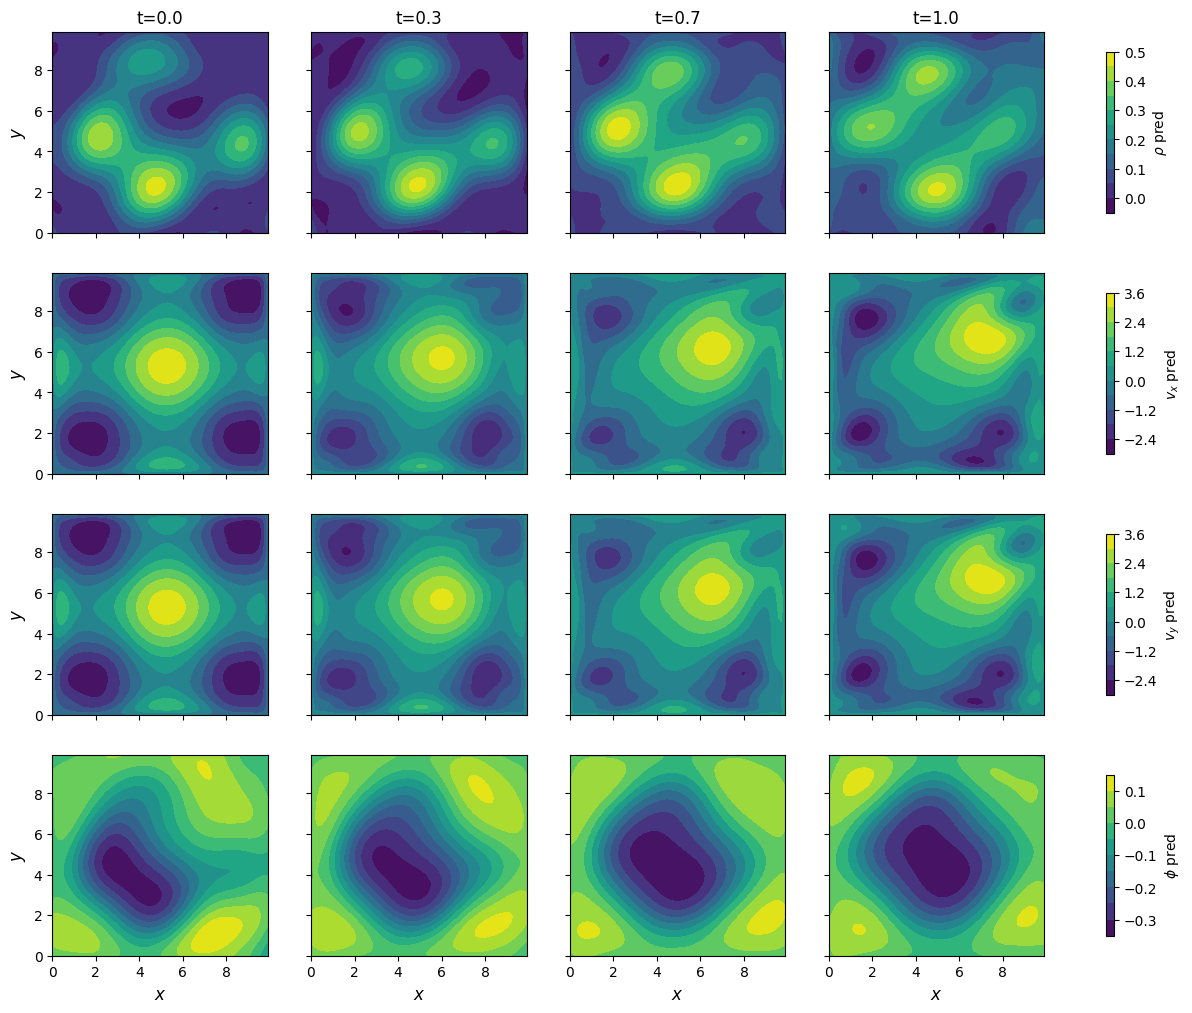

In [31]:
time_array = np.linspace(0, int(tmax), int(tmax) + 3)
n_times = len(time_array)

fig, axes = plt.subplots(4, n_times, sharex=True, sharey='row', figsize=(4*n_times, 12), gridspec_kw={'width_ratios': [1]*n_times, 'height_ratios': [1,1,1,1]})
fig.subplots_adjust(hspace=0.2, wspace=0.2)

# Adjust to loop over both rows and columns
for j, time in enumerate(time_array):
    # Create 2D grid
    x = np.linspace(xmin, xmax, 100)
    y = np.linspace(ymin, ymax, 100)
    X, Y = np.meshgrid(x, y)
    
    # Prepare network inputs
    xy_grid = np.hstack([X.reshape(-1, 1), Y.reshape(-1, 1)])
    t_grid = time * np.ones((xy_grid.shape[0], 1))
    
    pt_xy = torch.tensor(xy_grid, dtype=torch.float32).to(device)
    pt_t = torch.tensor(t_grid, dtype=torch.float32).to(device)
    
    # Get predictions
    with torch.no_grad():
        outputs = net(pt_xy, pt_t)
        rho_pred = outputs[:, 0:1].cpu().numpy().reshape(X.shape)
        v_0x_pred = outputs[:, 1:2].cpu().numpy().reshape(X.shape)
        v_0y_pred = outputs[:, 2:3].cpu().numpy().reshape(X.shape)
        phi_pred = outputs[:, 3:4].cpu().numpy().reshape(X.shape)

    #rho_LT = fun_rho_0(X, Y)
    #v_0x_LT, v_0y_LT, v_0_LT = fun_v_0(X, Y)

    #rho_diff = rho_pred - rho_LT
    #v_0x_diff = v_0x_pred - v_0x_LT
    #v_0y_diff = v_0y_pred - v_0y_LT

    im0 = axes[0,j].contourf(X, Y, rho_pred, levels=10, cmap='viridis')
    axes[0,j].set_title(f"t={time:.1f}")
    if j == 0:
        axes[0,j].set_ylabel(r"$y$", fontsize=12)
    
    # Plot vx mismatch
    im1 = axes[1,j].contourf(X, Y, v_0x_pred, levels=10, cmap='viridis')
    if j == 0:
        axes[1,j].set_ylabel(r"$y$", fontsize=12)
    
    # Plot vy mismatch
    im2 = axes[2,j].contourf(X, Y, v_0y_pred, levels=10, cmap='viridis')
    if j == 0:
        axes[2,j].set_ylabel(r"$y$", fontsize=12)

    # Plot phi mismatch
    im3 = axes[3,j].contourf(X, Y, phi_pred, levels=10, cmap='viridis')
    if j == 0:
        axes[3,j].set_ylabel(r"$y$", fontsize=12)
    
    # Common formatting
    for i in range(4):
        axes[i,j].set_xlabel(r"$x$" if i==3 else "", fontsize=12)
        axes[i,j].tick_params(labelsize=10)

# Add colorbars
fig.colorbar(im0, ax=axes[0,:], shrink=0.8, aspect=20, label=r'$\rho$ pred')
fig.colorbar(im1, ax=axes[1,:], shrink=0.8, aspect=20, label='$v_x$ pred')
fig.colorbar(im2, ax=axes[2,:], shrink=0.8, aspect=20, label='$v_y$ pred')
fig.colorbar(im3, ax=axes[3,:], shrink=0.8, aspect=20, label=r'$\phi$ pred')

plt.show()

## Theory plots

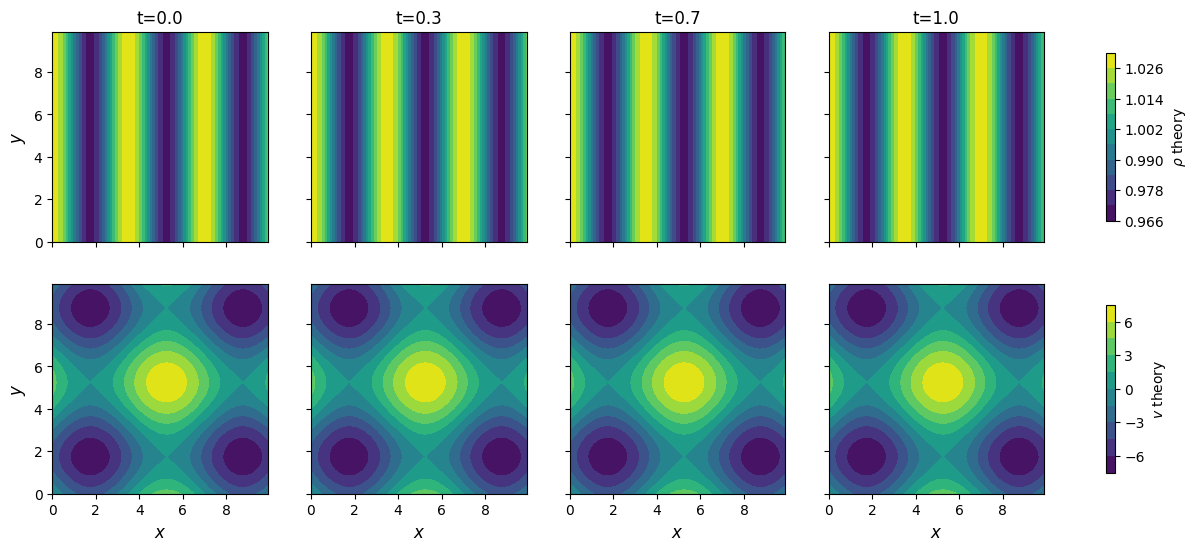

In [44]:
#time_array = np.linspace(0, int(tmax), int(tmax) + 3)
n_times = len(time_array)

fig, axes = plt.subplots(2, n_times, sharex=True, sharey='row', figsize=(4*n_times, 6), gridspec_kw={'width_ratios': [1]*n_times, 'height_ratios': [1,1]})
fig.subplots_adjust(hspace=0.2, wspace=0.2)

# Adjust to loop over both rows and columns
for j, time in enumerate(time_array):
    # Create 2D grid
    x = np.linspace(xmin, xmax, 100)
    y = np.linspace(ymin, ymax, 100)
    X, Y = np.meshgrid(x, y)
    
    # Prepare network inputs
    xy_grid = np.hstack([X.reshape(-1, 1), Y.reshape(-1, 1)])
    t_grid = time * np.ones((xy_grid.shape[0], 1))
    
    pt_xy = torch.tensor(xy_grid, dtype=torch.float32).to(device)
    pt_t = torch.tensor(t_grid, dtype=torch.float32).to(device)
    
    # Get predictions
    with torch.no_grad():
        outputs = net(pt_xy, pt_t)
        rho_pred = outputs[:, 0:1].cpu().numpy().reshape(X.shape)
        v_0x_pred = outputs[:, 1:2].cpu().numpy().reshape(X.shape)
        v_0y_pred = outputs[:, 2:3].cpu().numpy().reshape(X.shape)
        # phi_pred = outputs[:, 3:4].cpu().numpy().reshape(X.shape)

    rho_LT = fun_rho_0(X, Y)
    v_0x_LT, v_0y_LT, v_0_LT = fun_v_0(X, Y)

    rho_diff = rho_pred - rho_LT
    #v_0x_diff = v_0x_pred - v_0x_LT
    #v_0y_diff = v_0y_pred - v_0y_LT

    v_0_diff = v_0_LT - np.sqrt(v_0x_pred**2 + v_0y_pred**2)

    im0 = axes[0,j].contourf(X, Y, rho_LT, levels=10, cmap='viridis')
    axes[0,j].set_title(f"t={time:.1f}")
    if j == 0:
        axes[0,j].set_ylabel(r"$y$", fontsize=12)
    
    # Plot vx mismatch
    im1 = axes[1,j].contourf(X, Y, v_0_LT, levels=10, cmap='viridis')
    if j == 0:
        axes[1,j].set_ylabel(r"$y$", fontsize=12)
    
    # Common formatting
    for i in range(2):
        axes[i,j].set_xlabel(r"$x$" if i==1 else "", fontsize=12)
        axes[i,j].tick_params(labelsize=10)

# Add colorbars
fig.colorbar(im0, ax=axes[0,:], shrink=0.8, aspect=20, label=r'$\rho$ theory')
fig.colorbar(im1, ax=axes[1,:], shrink=0.8, aspect=20, label='$v$ theory')

plt.show()

#### Mismatch between theory and predictions (seperating x and y components of velocity using assumption mentioned in comment)

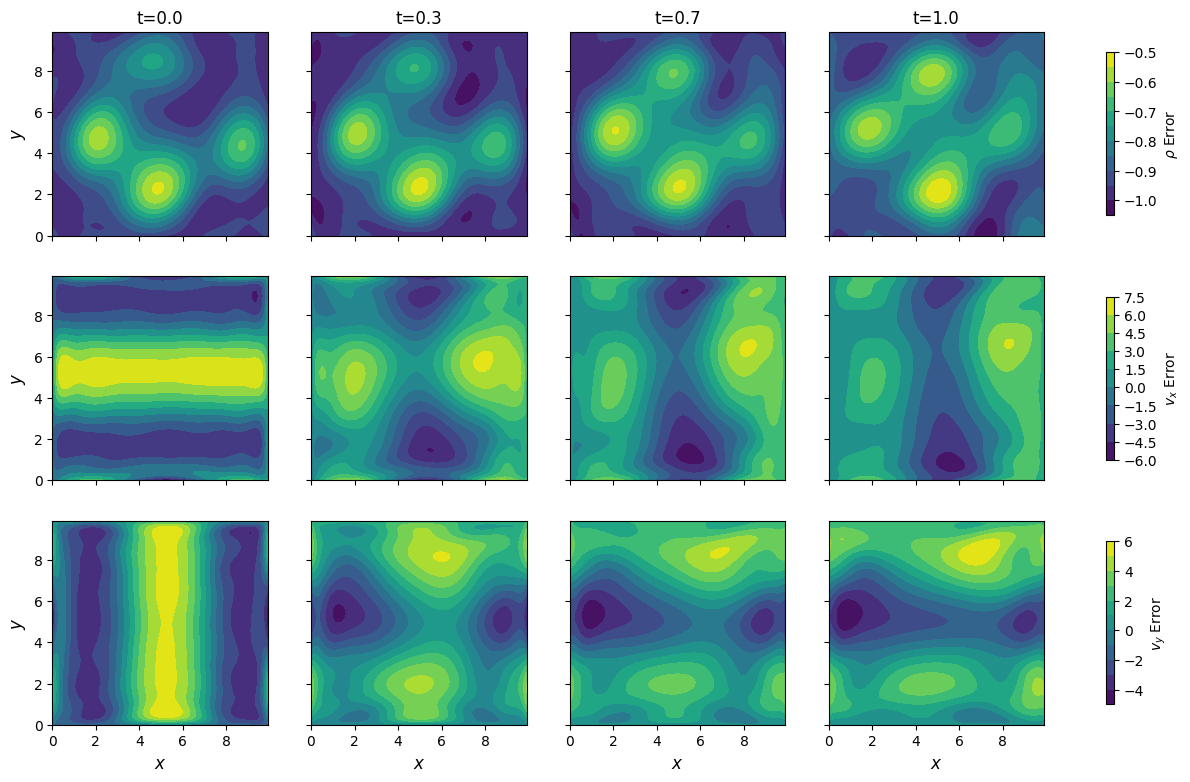

In [45]:
#time_array = np.linspace(0, int(tmax), int(tmax) + 3)
n_times = len(time_array)

fig, axes = plt.subplots(3, n_times, sharex=True, sharey='row', figsize=(4*n_times, 9), gridspec_kw={'width_ratios': [1]*n_times, 'height_ratios': [1,1,1]})
fig.subplots_adjust(hspace=0.2, wspace=0.2)

# Adjust to loop over both rows and columns
for j, time in enumerate(time_array):
    # Create 2D grid
    x = np.linspace(xmin, xmax, 100)
    y = np.linspace(ymin, ymax, 100)
    X, Y = np.meshgrid(x, y)
    
    # Prepare network inputs
    xy_grid = np.hstack([X.reshape(-1, 1), Y.reshape(-1, 1)])
    t_grid = time * np.ones((xy_grid.shape[0], 1))
    
    pt_xy = torch.tensor(xy_grid, dtype=torch.float32).to(device)
    pt_t = torch.tensor(t_grid, dtype=torch.float32).to(device)
    
    # Get predictions
    with torch.no_grad():
        outputs = net(pt_xy, pt_t)
        rho_pred = outputs[:, 0:1].cpu().numpy().reshape(X.shape)
        v_0x_pred = outputs[:, 1:2].cpu().numpy().reshape(X.shape)
        v_0y_pred = outputs[:, 2:3].cpu().numpy().reshape(X.shape)
        # phi_pred = outputs[:, 3:4].cpu().numpy().reshape(X.shape)

    rho_LT = fun_rho_0(X, Y)
    v_0x_LT, v_0y_LT, v_0_LT = fun_v_0(X, Y)

    rho_diff = rho_pred - rho_LT
    v_0x_diff = v_0x_pred - v_0x_LT
    v_0y_diff = v_0y_pred - v_0y_LT

    im0 = axes[0,j].contourf(X, Y, rho_diff, levels=10, cmap='viridis')
    axes[0,j].set_title(f"t={time:.1f}")
    if j == 0:
        axes[0,j].set_ylabel(r"$y$", fontsize=12)
    
    # Plot vx mismatch
    im1 = axes[1,j].contourf(X, Y, v_0x_diff, levels=10, cmap='viridis')
    if j == 0:
        axes[1,j].set_ylabel(r"$y$", fontsize=12)
    
    # Plot vy mismatch
    im2 = axes[2,j].contourf(X, Y, v_0y_diff, levels=10, cmap='viridis')
    if j == 0:
        axes[2,j].set_ylabel(r"$y$", fontsize=12)
    
    # Common formatting
    for i in range(3):
        axes[i,j].set_xlabel(r"$x$" if i==2 else "", fontsize=12)
        axes[i,j].tick_params(labelsize=10)

# Add colorbars
fig.colorbar(im0, ax=axes[0,:], shrink=0.8, aspect=20, label=r'$\rho$ Error')
fig.colorbar(im1, ax=axes[1,:], shrink=0.8, aspect=20, label='$v_x$ Error')
fig.colorbar(im2, ax=axes[2,:], shrink=0.8, aspect=20, label='$v_y$ Error')

plt.show()

#### Mismatch between theory and prediction (combining x and y component of velocity from predictions and comparing magnitudes)

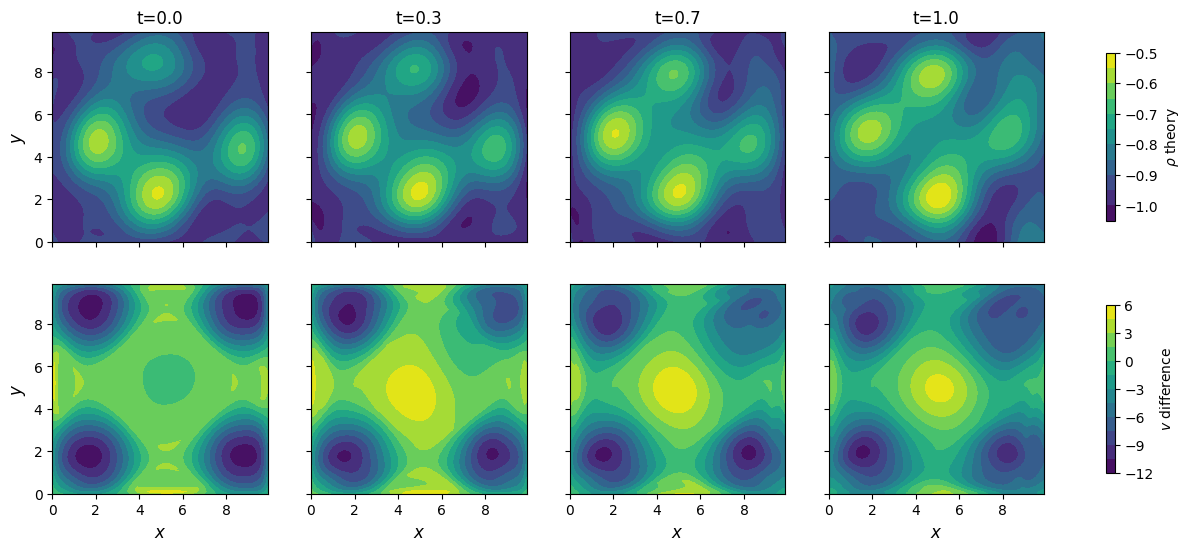

In [ ]:
#time_array = np.linspace(0, int(tmax), int(tmax) + 3)
n_times = len(time_array)

fig, axes = plt.subplots(2, n_times, sharex=True, sharey='row', figsize=(4*n_times, 6), gridspec_kw={'width_ratios': [1]*n_times, 'height_ratios': [1,1]})
fig.subplots_adjust(hspace=0.2, wspace=0.2)

# Adjust to loop over both rows and columns
for j, time in enumerate(time_array):
    # Create 2D grid
    x = np.linspace(xmin, xmax, 100)
    y = np.linspace(ymin, ymax, 100)
    X, Y = np.meshgrid(x, y)
    
    # Prepare network inputs
    xy_grid = np.hstack([X.reshape(-1, 1), Y.reshape(-1, 1)])
    t_grid = time * np.ones((xy_grid.shape[0], 1))
    
    pt_xy = torch.tensor(xy_grid, dtype=torch.float32).to(device)
    pt_t = torch.tensor(t_grid, dtype=torch.float32).to(device)
    
    # Get predictions
    with torch.no_grad():
        outputs = net(pt_xy, pt_t)
        rho_pred = outputs[:, 0:1].cpu().numpy().reshape(X.shape)
        v_0x_pred = outputs[:, 1:2].cpu().numpy().reshape(X.shape)
        v_0y_pred = outputs[:, 2:3].cpu().numpy().reshape(X.shape)
        # phi_pred = outputs[:, 3:4].cpu().numpy().reshape(X.shape)

    rho_LT = fun_rho_0(X, Y)
    v_0x_LT, v_0y_LT, v_0_LT = fun_v_0(X, Y)

    rho_diff = rho_pred - rho_LT
    #v_0x_diff = v_0x_pred - v_0x_LT
    #v_0y_diff = v_0y_pred - v_0y_LT

    v_0_diff = v_0_LT - np.sqrt(v_0x_pred**2 + v_0y_pred**2)  #computing the magnitude difference between the predicted and theoretical velocity

    im0 = axes[0,j].contourf(X, Y, rho_diff, levels=10, cmap='viridis')
    axes[0,j].set_title(f"t={time:.1f}")
    if j == 0:
        axes[0,j].set_ylabel(r"$y$", fontsize=12)
    
    # Plot vx mismatch
    im1 = axes[1,j].contourf(X, Y, v_0_diff, levels=10, cmap='viridis')
    if j == 0:
        axes[1,j].set_ylabel(r"$y$", fontsize=12)
    
    # Common formatting
    for i in range(2):
        axes[i,j].set_xlabel(r"$x$" if i==1 else "", fontsize=12)
        axes[i,j].tick_params(labelsize=10)

# Add colorbars
fig.colorbar(im0, ax=axes[0,:], shrink=0.8, aspect=20, label=r'$\rho$ theory')
fig.colorbar(im1, ax=axes[1,:], shrink=0.8, aspect=20, label='$v$ difference')

plt.show()

In [ ]:
'''def plots(net, time_array, initial_params, output_folder = None):
    xmin, xmax, ymin, ymax, rho_1, lam, tmax = initial_params
    
    for t in time_array:
        
        # Create 2D grid
        x = np.linspace(xmin, xmax, 100)
        y = np.linspace(ymin, ymax, 100)
        X, Y = np.meshgrid(x, y)
        
        # Prepare network inputs
        xy_grid = np.hstack([X.reshape(-1,1), Y.reshape(-1,1)])
        t_grid = t * np.ones((xy_grid.shape[0], 1))
        
        pt_xy = torch.tensor(xy_grid, dtype=torch.float32).to(device)
        pt_t = torch.tensor(t_grid, dtype=torch.float32).to(device)
        
        # Get predictions
        with torch.no_grad():
            outputs = net(pt_xy, pt_t)
            rho_pred = outputs[:, 0:1].cpu().numpy().reshape(X.shape)
            v_0x_pred = outputs[:, 1:2].cpu().numpy().reshape(X.shape)
            v_0y_pred = outputs[:, 2:3].cpu().numpy().reshape(X.shape)
            #phi_pred = outputs[:, 3:4].cpu().numpy().reshape(X.shape)

        fig, axes = plt.subplots(6, 4, sharex=True, sharey='row', figsize=(16,9), gridspec_kw={'width_ratios':[1,1,1], 'height_ratios':[3,1.2,3,1.2]})
        
        # Plotting
        plt.figure(figsize=(8,6))
        plt.contourf(X, Y, rho_pred, levels=50, cmap='viridis')
        plt.colorbar(label='Density (rho)')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title(f'2D Density Distribution at t={t:.2f}')
        #plt.savefig(f'{output_folder}/2d_density_t_{t:.2f}.png', dpi=300)
        #plt.close()
'''

In [ ]:
'''def plot_3d_density(net, t, xmin, xmax, ymin, ymax, device="cpu"):
    """
    net: Trained PINN model
    t: Time value to plot (float)
    xmin/xmax/ymin/ymax: Spatial domain bounds
    device: Device where the model resides (e.g., "cuda" or "cpu")
    """
    # Create 2D grid
    x = np.linspace(xmin, xmax, 100)
    y = np.linspace(ymin, ymax, 100)
    X, Y = np.meshgrid(x, y)
    
    # Prepare inputs for the network
    xy_grid = np.hstack([X.reshape(-1,1), Y.reshape(-1,1)])  # Shape [10000, 2]
    t_grid = t * np.ones((xy_grid.shape[0], 1))              # Shape [10000, 1]
    
    # Convert to PyTorch tensors
    pt_xy = torch.tensor(xy_grid, dtype=torch.float32).to(device)
    pt_t = torch.tensor(t_grid, dtype=torch.float32).to(device)
    
    # Get predictions (disable gradient tracking)
    with torch.no_grad():
        outputs = net(pt_xy, pt_t)
        rho_pred = outputs[:,0].cpu().numpy().reshape(X.shape)  # Reshape to 100x100
    
    # Create 3D plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, rho_pred, cmap='viridis', edgecolor='none')
    
    # Customize plot
    ax.set_xlabel('X', fontsize=12)
    ax.set_ylabel('Y', fontsize=12)
    ax.set_zlabel(r'$\rho$', fontsize=12)
    ax.set_title(f'Density Distribution at t = {t:.2f}', fontsize=14)
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, label='Density')
    
    plt.show()

for t_plot in np.linspace(0,int(tmax),int(tmax)+3):
    plot_3d_density(net, t_plot, xmin, xmax, ymin, ymax, device="cuda")'''